In [ ]:
from utils.binaries import *
from utils.plotting import *

from scipy.optimize import curve_fit

def exp

16:38:38 (   +5.2s) [INFO   ] -- import logging
16:38:38 (  +178ms) [INFO   ] -- import numpy as np
16:38:38 (   +11ms) [INFO   ] -- import uncertainties
16:38:39 (  +417ms) [INFO   ] -- import pandas as pd
16:38:39 (    +2ms) [WARNING] -- pandas support to be dropped at some point!
16:38:39 (    +2ms) [INFO   ] -- import binaries.tools as tools
16:38:39 (  +417ms) [INFO   ] -- import matplotlib.pyplot as plt
16:38:40 (  +558ms) [INFO   ] -- import seaborn as so
16:38:40 (    +2ms) [INFO   ] -- set MONI_PATH = PosixPath('/cr/work/filip/monit_and_sd')
16:38:40 (    +1ms) [INFO   ] -- set HIST_PATH = PosixPath('/cr/work/filip/monit_and_sd')
16:38:40 (    +1ms) [INFO   ] -- set PLOT_PATH = PosixPath('/cr/data01/filip/plots')
16:38:40 (    +1ms) [INFO   ] -- set DATA_PATH = PosixPath('/cr/data01/filip/Data')
16:38:40 (    +1ms) [INFO   ] -- set SCAN_PATH = PosixPath('/cr/data01/filip/xy-calibration')
16:38:40 (    +1ms) [INFO   ] -- set OFLN_PATH = PosixPath('/cr/data01/filip/offline/insta

Text(0.5, 0, '$I^\\mathrm{SSD}_\\mathrm{histo}$')

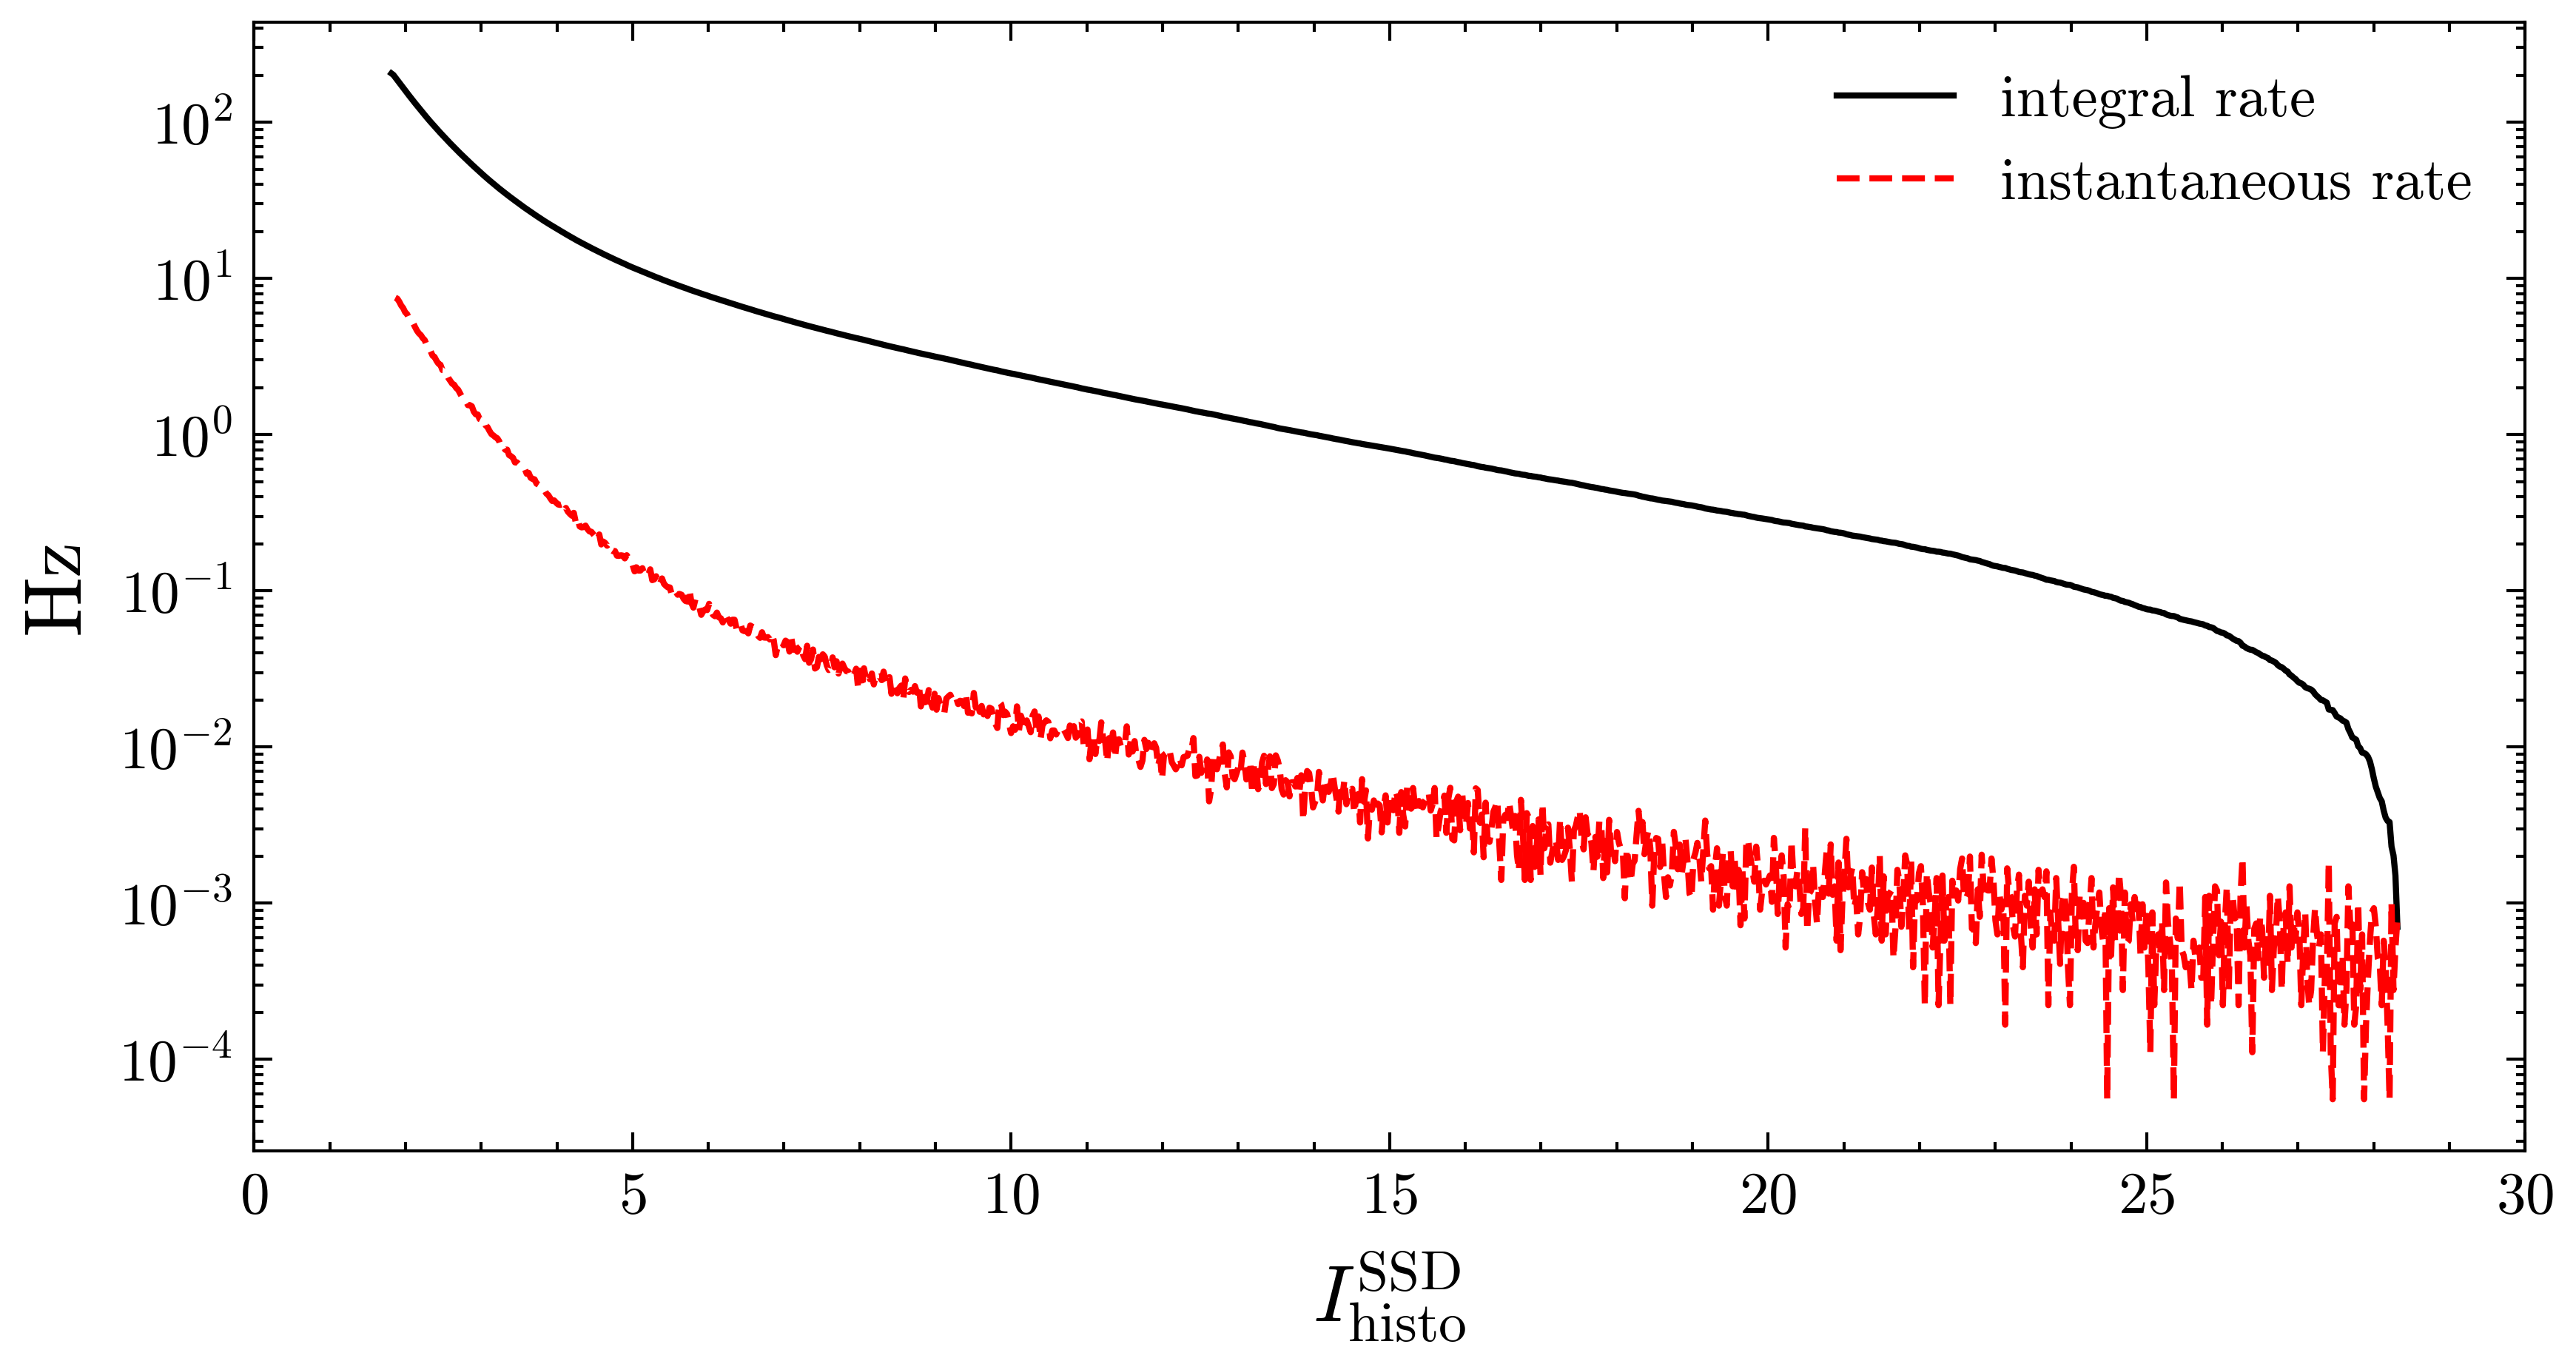

In [21]:
x, y = np.loadtxt('/cr/data01/filip/Data/muonAcquisition/mean_rates_t3_mip.txt', unpack=True)

plt.plot(x, y, label='integral rate')
plt.plot(x[2:], -np.diff(y[1:]), c='r', label='instantaneous rate', marker='none')

plt.legend()
plt.xlim(0, 30)
plt.ylabel("Hz")
plt.yscale('log')
plt.xlabel("$I^\mathrm{SSD}_\mathrm{histo}$")

In [57]:
# from data

t_cal = 10
t_70 = 50 / 48.94       # real world values
adjust = 0.2 / 48.94    # maybe this has an influence?
mip, rate = np.loadtxt('/cr/data01/filip/Data/muonAcquisition/mean_rates_t3_mip.txt', unpack=True)
i_ssd, inst_rate = mip[2:], -np.diff(rate[1:])

n_repeat = 5

while t_cal <= 60 or n_repeat:


    # create events
    peaks = np.array([])
    for x, y in zip(i_ssd, inst_rate):
        peaks = np.append(peaks, [x] * np.random.poisson(y * t_cal))
    
    # calculate trigger rate
    n_above = sum(peaks >= t_70)
    trigger_rate = n_above / t_cal
    sigma = np.sqrt(trigger_rate)
    delta = trigger_rate - 70

    match delta:
        case _ if np.abs(delta) < sigma:
            adjust -= 0.01 / 48.94
            t_cal += 5
        
        case _ if np.abs(delta) < 5:
            adjust = 0.1 / 48.94

        case _ if np.abs(delta) < 20:
            pass
        
        case _:
            adjust = 1.0 / 48.94
            t_cal = 10

    t_cal = min([61, np.max([10, t_cal])])
    adjust = min([1. / 48.94, np.max([0.01 / 48.94, t_cal])])

    if delta > 0: t_70 += adjust
    else:         t_70 -= adjust

    if t_cal >= 60: 
        n_repeat -= 1
        
        print(f"after {t_cal = } s, rate was {trigger_rate:.2f} Hz and threshold will be {t_70:.2f} (= {t_70/2.64-1:.2f})")

after t_cal = 60 s, rate was 69.82 Hz and threshold will be 2.62 (= -0.01)
after t_cal = 61 s, rate was 75.95 Hz and threshold will be 2.64 (= -0.00)
after t_cal = 61 s, rate was 71.75 Hz and threshold will be 2.66 (= 0.01)
after t_cal = 61 s, rate was 69.33 Hz and threshold will be 2.64 (= -0.00)
after t_cal = 61 s, rate was 71.41 Hz and threshold will be 2.66 (= 0.01)
